<a href="https://colab.research.google.com/github/pragathi916/SKIN_CANCER_DETECTION/blob/main/MOBILENET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ======================= SETUP ===========================
!pip install -q kaggle torchvision scikit-learn matplotlib seaborn

import os, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, roc_curve, classification_report, f1_score
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from google.colab import files


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.2 MB/s eta 0:00:00


In [3]:
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip
!mkdir -p HAM10000_images
!cp HAM10000_images_part_1/* HAM10000_images/
!cp HAM10000_images_part_2/* HAM10000_images/


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.19G/5.20G [01:49<00:00, 20.9MB/s]
100% 5.20G/5.20G [01:49<00:00, 51.0MB/s]


In [4]:
df = pd.read_csv("HAM10000_metadata.csv")
df['label'] = df['dx'].apply(lambda x: 1 if x in ['mel', 'bkl', 'bcc', 'akiec'] else 0)

# Optional: Use smaller data for fast prototyping
df = df.groupby("label").apply(lambda x: x.sample(500, random_state=42)).reset_index(drop=True)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'], random_state=42)


<ipython-input-4-b47fc9c62d72>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label").apply(lambda x: x.sample(500, random_state=42)).reset_index(drop=True)


In [5]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.loc[idx, 'image_id'] + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'label']
        if self.transform:
            image = self.transform(image)
        return image, label


In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Faster training
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def get_loaders(batch_size=32):
    return (
        DataLoader(SkinLesionDataset(train_df, "HAM10000_images", transform), batch_size=batch_size, shuffle=True, num_workers=2),
        DataLoader(SkinLesionDataset(val_df, "HAM10000_images", transform), batch_size=batch_size, num_workers=2),
        DataLoader(SkinLesionDataset(test_df, "HAM10000_images", transform), batch_size=batch_size, num_workers=2)
    )


In [15]:
def get_model(model_name, dropout=0.5):
    if model_name == 'mobilenet':
        model = models.mobilenet_v2(pretrained=True)
        for param in model.features.parameters():
            param.requires_grad = False  # Freeze feature extractor

        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, 1)
        )
    elif model_name == 'googlenet':
        model = models.googlenet(pretrained=True, aux_logits=False)
        for param in model.parameters():
            param.requires_grad = True  # You can freeze layers as needed

        in_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(in_features, 1)
        )
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    return model


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5):
    model.to(device)
    best_auc = 0
    history = {'val_auc': []}

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_labels, val_scores = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images).squeeze()
                probs = torch.sigmoid(outputs)
                val_scores.extend(probs.cpu().numpy())
                val_labels.extend(labels.numpy())

        val_auc = roc_auc_score(val_labels, val_scores)
        print(f"Epoch {epoch+1}: AUC = {val_auc:.4f}")
        history['val_auc'].append(val_auc)

        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), "best_model.pth")

    return history


In [22]:
from sklearn.metrics import roc_auc_score, accuracy_score

def evaluate(model, dataloader):
    model.eval()
    model.to(device)

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images).squeeze()
            probs = torch.sigmoid(outputs).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.numpy())

    # Binarize predictions using threshold 0.5
    preds = [1 if p >= 0.5 else 0 for p in all_probs]

    auc = roc_auc_score(all_labels, all_probs)
    acc = accuracy_score(all_labels, preds)
    return acc, auc


In [10]:
def predict_image(image_path, model):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    transform_img = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5]*3, [0.5]*3)
    ])
    img_tensor = transform_img(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor).squeeze()
        prob = torch.sigmoid(output).item()
        pred = "Cancer" if prob > 0.5 else "Non-Cancer"
    print(f"Prediction: {pred} (Probability: {prob:.2f})")
    plt.imshow(image)
    plt.title(pred)
    plt.axis('off')
    plt.show()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 117MB/s]


Epoch 1: AUC = 0.4400
Epoch 2: AUC = 0.6772
Epoch 3: AUC = 0.7308
Epoch 4: AUC = 0.7724
Epoch 5: AUC = 0.7908
              precision    recall  f1-score   support

  Non-Cancer       0.73      0.76      0.75        50
      Cancer       0.75      0.72      0.73        50

    accuracy                           0.74       100
   macro avg       0.74      0.74      0.74       100
weighted avg       0.74      0.74      0.74       100



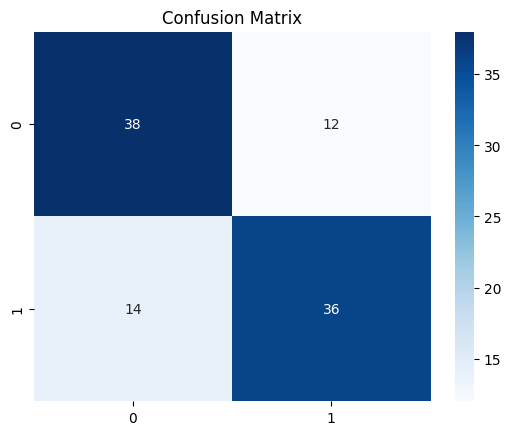

In [11]:
train_loader, val_loader, test_loader = get_loaders(batch_size=32)
model = get_model()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

history = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5)
model.load_state_dict(torch.load("best_model.pth"))
evaluate(model, test_loader)


Saving 2.jpeg to 2.jpeg
Prediction: Cancer (Probability: 0.80)


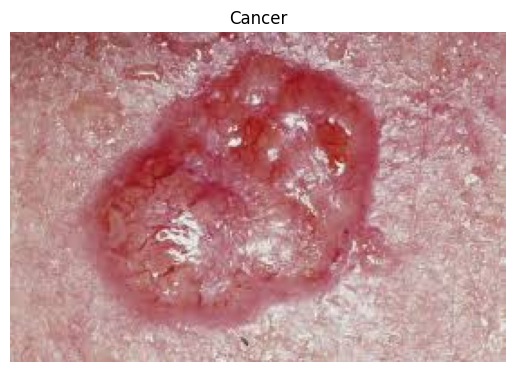

In [12]:
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
predict_image(img_path, model)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: AUC = 0.6160
Epoch 2: AUC = 0.7144
Epoch 3: AUC = 0.7420
Epoch 4: AUC = 0.7736
Epoch 5: AUC = 0.7964


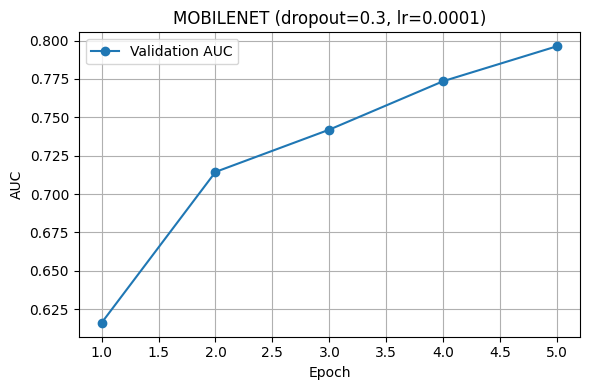


--- Training Summary ---
Model        : mobilenet
Dropout      : 0.3
Learning Rate: 0.0001
Batch Size   : 32
Epochs       : 5
Best Val AUC : 0.7964
Test Accuracy: 0.7700
Test AUC     : 0.8136


In [25]:
model_name = 'mobilenet'
dropout = 0.3
lr = 1e-4
batch_size = 32
epochs = 5
optimizer_type = 'adam'

train_loader, val_loader, test_loader = get_loaders(batch_size)
model = get_model(model_name, dropout)

optimizer = optim.Adam(model.parameters(), lr=lr) if optimizer_type == 'adam' else optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.BCEWithLogitsLoss()

history = train_model(model, optimizer, criterion, train_loader, val_loader, epochs)
plot_metrics(history, f'{model_name.upper()} (dropout={dropout}, lr={lr})')

model.load_state_dict(torch.load("best_model.pth"))
test_acc, test_auc = evaluate(model, test_loader)
log_result(model_name, dropout, lr, batch_size, epochs, max(history['val_auc']), test_acc, test_auc)


In [24]:
def log_result(model_name, dropout, lr, batch_size, epochs, best_val_auc, test_acc, test_auc):
    print("\n--- Training Summary ---")
    print(f"Model        : {model_name}")
    print(f"Dropout      : {dropout}")
    print(f"Learning Rate: {lr}")
    print(f"Batch Size   : {batch_size}")
    print(f"Epochs       : {epochs}")
    print(f"Best Val AUC : {best_val_auc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC     : {test_auc:.4f}")


In [26]:
import matplotlib.pyplot as plt

def plot_metrics(history, title='Validation AUC'):
    epochs = range(1, len(history['val_auc']) + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, history['val_auc'], marker='o', label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
